# Glacier Dynamics Assumptions Initialization 

In our task of initializing steady state configurations for our nine test glaciers, we must make some assumptions about glacier dynamics. Namely, we must:  
  1. assume a value for rate-factor $A$ and   
  2. make an assumption about slip along the basal boundary. 
  
While in later experiment we will account for the thermo-mechanical effects of ice flow, we preform mass balance related parameter tuning assuming isothermal conditions with a rate-factor $A$ for temperate ice from _Cuffey and Paterson, 2010_. For the basal boundary condition, our initial inclination is assume no sliding for all our input glaciers. We seek to first, asses how reasonable of an assumption no sliding is for each glacier, and second, determine the optimal value for the slip coefficient if the no slip assumption proves to be unreasonable. 

### Observational Surface Velocities 

We use the [ITS_LIVE](https://its-live.jpl.nasa.gov/) 120 m annually averaged mosaics, extracted along each glacier flowline to produce a reference (observational) velocity profiles for each glacier. These reference velocity profile are then compared to diagnostic surface velocities produced with Elmer/Ice. 

In [2]:
import re
import os
import glob
import rasterio
import numpy as np
import xarray as xr
import geopandas as gpd
import scipy.signal as signal
from scipy import interpolate
import matplotlib.pyplot as plt 

def calc_bias(modeled, measured): 
    """Compute the mean bias (difference b/w modelled and observed results) 
    """
    return np.mean(modeled - measured)

def calc_perc_diff(modeled, measured): 
    """Compute the mean percent differnce b/w modelled and observed results
    """
    return np.mean(modeled - measured)

def calc_R_squared(modeled, measured):
    """Compute the R^2 b/w modelled and observed results
    """
    return np.corrcoef(modeled,measured)[1,0]

class flowline:
    """Class for easy extraction of shapefile to 
        flowline prodcut which can be used for Elmer geometry generation
    """
    
    def __init__(self, FL_shape):
        self.fp      = FL_shape
        self.shp_gdf = gpd.read_file(FL_shape)

    def shp_2_coords(self, dx=30):
        """Convert .shp line to discrete points spaced at specified dx.

        For reference see:
            https://stackoverflow.com/a/35025274/10221482
        """
        num_vert = int(round(self.shp_gdf.length[0] / dx))
        if num_vert == 0:
            num_vert = 1
        multipoint = [self.shp_gdf.interpolate(float(n)/num_vert,normalized=True) for n in range(num_vert + 1)]
        x_points = [multipoint[i].x[0] for i in range(len(multipoint))]
        y_points = [multipoint[i].y[0] for i in range(len(multipoint))]

        return [(x,y) for x,y in zip(x_points, y_points)]
    
    def shp_2_xarray(self, dx=30): 
        
        coords = self.shp_2_coords(dx=dx)
        
        x = xr.DataArray(np.array(coords)[:,0], dims="z")
        y = xr.DataArray(np.array(coords)[:,1], dims="z")
        # distance along flowline array
        d = xr.DataArray(np.arange(len(coords))*dx, dims="z")
        
        return x, y, d
    
    
class sampler:
    def __init__(self, src_fp):
        self.fp  = src_fp

    def extract(self, coords, dx):
        with rasterio.open(self.fp) as src:
            prof = [x[0] for x in src.sample(coords)]
            
            prof = np.where(np.array(prof)==src.nodata, np.nan, prof)
            
        return np.hstack([ np.arange(len(coords))[:,np.newaxis] * dx,
                           np.array(prof)[:, np.newaxis] ])



In [3]:
# The glaciers of interest that we want the Farinotti Beds for.
glaciers = { 
    
    'crmpt12'   : {'dx'  : 50,              # Δx [m]
                   'RGI' : "01.16732",
                   'Name': "Crompton #12"},
    'crmpt18-a' : {'dx'  : 50,              # Δx [m]
                   'RGI' : "01.16855",
                   'Name': "Crompton #18"},
    'glc1-a'    : {'dx'  : 50,              # Δx [m]
                   'RGI' : "01.16195",
                   'Name': "South"},
    'lilk-a'    : {'dx'  : 100,             # Δx [m]
                   'RGI' : "01.16198-LK",
                   'Name': "Little Kluane"},
    'klun-a'    : {'dx'  : 100,             # Δx [m]
                   'RGI' : "01.16198-BK",
                   'Name':  "Kluane"},
    'sprg'      : {'dx'  : 100,             # Δx [m]
                   'RGI' : "01.16262",
                   'Name':  "Spring"},
    'fish'      : {'dx'  : 200,             # Δx [m]
                   'RGI' : "01.16122",
                   'Name':  "Fisher"},
    'klut-a'    : {'dx'  : 200,             # Δx [m]
                   'RGI' : "01.17183",
                   'Name':  "Klutlan"},
    'twds-a'    : {'dx'  : 200,             # Δx [m]
                   'RGI' : "01.16121",
                   'Name': "Tweedsmuir"}
    }

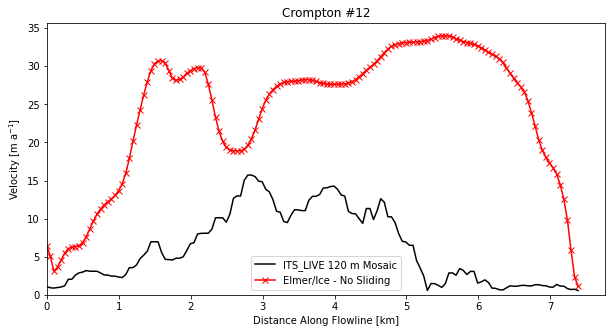

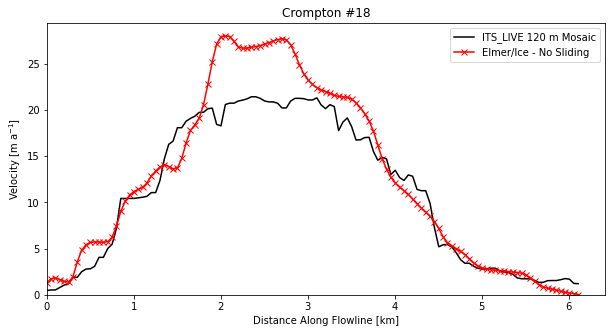

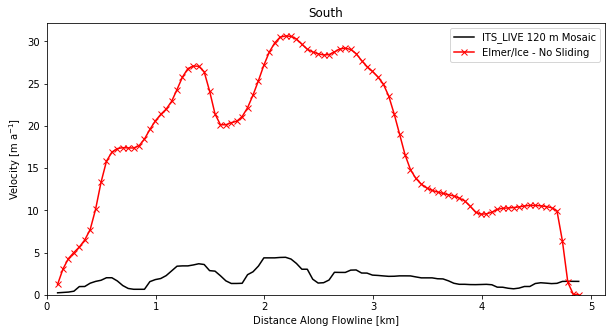

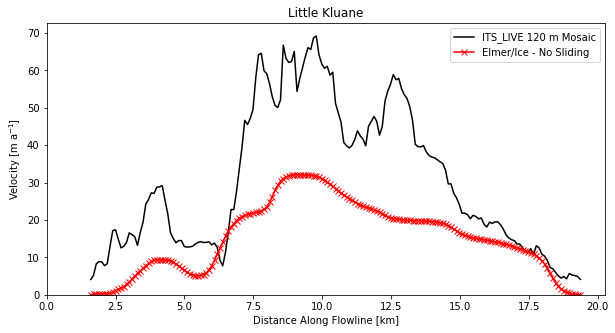

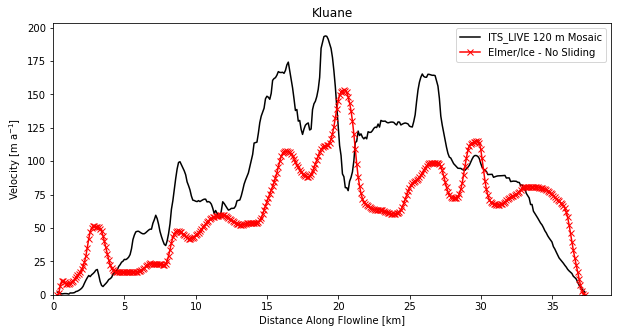

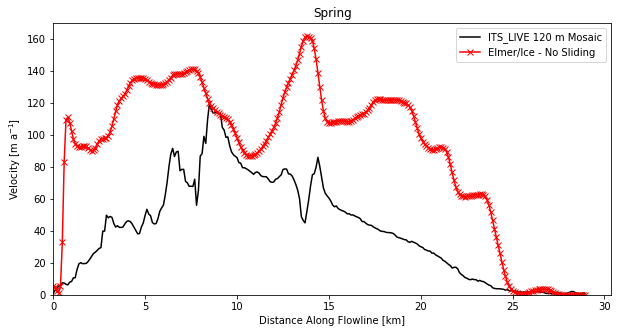

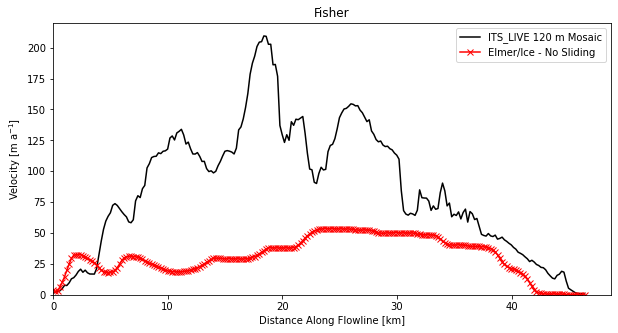

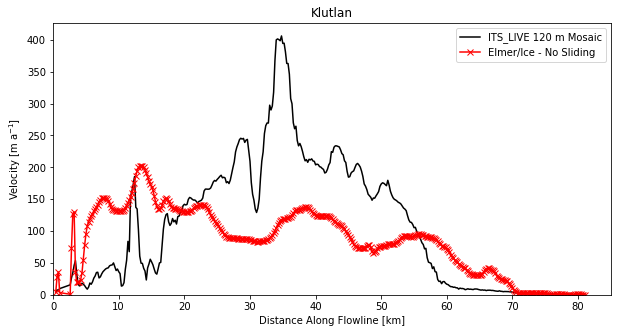

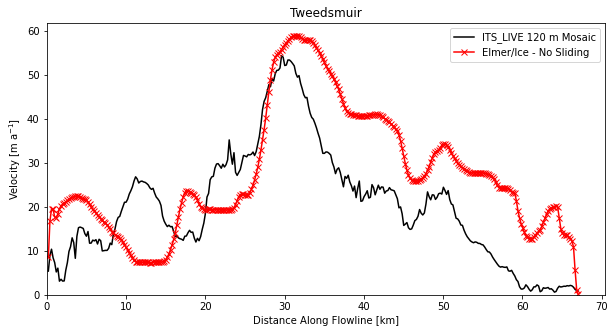

In [4]:
base_fp = "/Users/andrewnolan/Desktop/Big_Glaciers/Glaciers/"

v_m   = sampler('./data/ALA_G0120_0000_v_UTM7N.tif')
v_err = sampler('./data/ALA_G0120_0000_v_err_UTM7N.tif')

# filepath relative to top of git repo
nc_base = "./result/{}/nc/{}_dx_{}_Beta_1.0.nc"

# empty vectors to store our metrics in 
bias      = []
perc_diff = []
R_squared  = []

# Loop of the RGI_IDs
for key in glaciers.keys():

    Δx     = glaciers[key]['dx']
    out_fp = nc_base.format(key,key,Δx)
    RGI_ID = glaciers[key]['RGI'] 
    
    ####################  
    # Read ITS_LIVE Data
    ####################
    # create glob string to find all flowlines in the manual flowlines
    # directory. There will often be more than one (i.e. flowine a versus b)
    dir_fp = os.path.join(base_fp, 
             "RGI60-{}/Manual_FL/Manual_FL-{}*.shp".format(*[RGI_ID,]*2))
    for i, fl_fp in enumerate(glob.glob(dir_fp)): 
        # Only deal with main flowlines now, not secondary flowlines
        if all([True if sub not in fl_fp else False for sub in ['-2.shp', '-S.shp', '_old.shp']]):
            # initialize the flowline using our defined class
            FL  = flowline(fl_fp)
        
            # extract discretized flowline information from shapefile
            coords = flowline(fl_fp).shp_2_coords(60)
            
            velocity = v_m.extract(coords, 60)
            error    = v_err.extract(coords, 60)
            
    ############################
    # Read Elmer No Sliding Data
    ############################
    with xr.open_dataset(out_fp) as src: 
        # correct for minimum ice thickness
        src["depth"] = xr.where(src.depth <= 10, 0, src.depth)
        # apply sigma coordinate transform for vertical coordinate
        src["Z"]     = src.zbed + src.Z * src.height 
        # Calculate the magnitude of the velocity vectors
        src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)    

        
        
    ###########################################
    # Interpolate ITS_LIVE Data onto Elmer Grid
    ###########################################
    f = interpolate.interp1d(velocity[:,0], velocity[:,1], 
                             kind='linear', fill_value="extrapolate")    
    ITS = f(src.coord_1[::-1])
    
    # Valid ice-thickness map
    mask = np.where(src.depth.isel(t=-1, coord_2=0).values > 0 )[0]
    
    ###########################################
    # Compute quality metrics
    ###########################################  
    bias.append(      calc_bias(src.isel(t=-1, coord_2=-1).vel_m[mask].values, 
                                ITS[mask]))           
    perc_diff.append( calc_perc_diff(src.isel(t=-1, coord_2=-1).vel_m[mask].values, 
                                     ITS[mask]))  
    R_squared.append(  calc_R_squared(src.isel(t=-1, coord_2=-1).vel_m[mask].values, 
                                    ITS[mask]))   

    ###########################################
    # Plot the Elmer and ITS_LIVE Data
    ###########################################   
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title(glaciers[key]['Name'])
    ax.plot(src.coord_1[::-1][mask]/1e3, 
            ITS[mask], c='k', 
            label='ITS_LIVE 120 m Mosaic')

    ax.plot(src.coord_1[::-1][mask]/1e3, 
            src.isel(t=-1, coord_2=-1).vel_m[mask], 'r-x',
            label='Elmer/Ice - No Sliding') 
        
    ax.legend()
    ax.set_ylabel('Velocity [m a$^{-1}$]')
    ax.set_xlabel('Distance Along Flowline [km]')

    ax.set_ylim(0.0, None)
    ax.set_xlim(0.0, None)
    
    


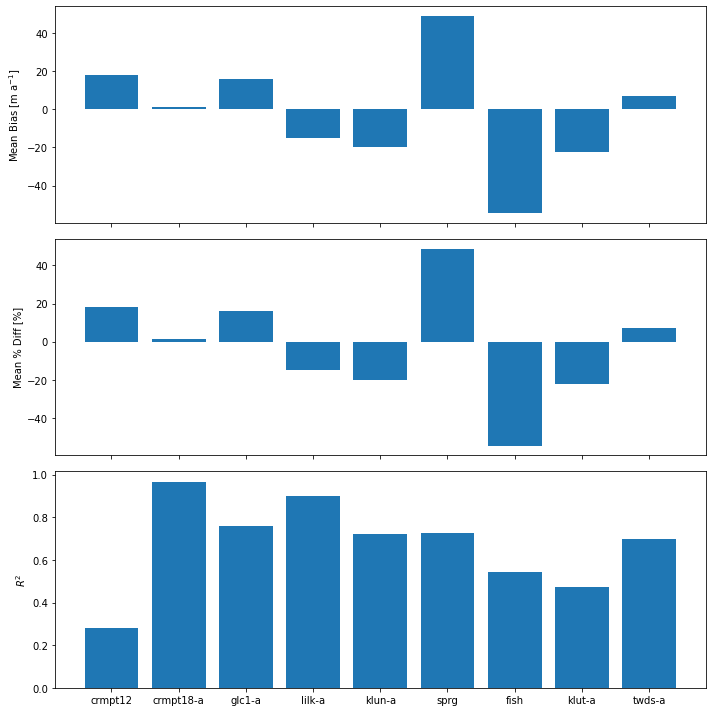

In [13]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,10))

ax[0].bar(glaciers.keys(), bias)
#ax[0].set_title('Mean Bias') 
ax[0].set_ylabel('Mean Bias [m a$^{-1}$]')
ax[1].bar(glaciers.keys(), perc_diff)
ax[1].set_ylabel('Mean % Diff [%]')
ax[2].bar(glaciers.keys(), R_squared)
ax[2].set_ylabel('$R^2$')

plt.tight_layout()